In [1]:
import pandas as pd
import os
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리  
from functools import partial               # 함수 변수 고정
import lightgbm as lgb                      # LightGBM 라이브러리
import warnings            
warnings.filterwarnings("ignore")

In [36]:
df_cw = pd.read_csv('/opt/ml/code/Lgbm/dataset/cw_train.csv')
df_jh = pd.read_csv('/opt/ml/code/Lgbm/dataset/jh_train.csv')
df_dh = pd.read_csv('/opt/ml/code/Lgbm/dataset/dh_train.csv')

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [42]:
df_jh

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_level_diff_itemID,test_level_diff_KnowledgeTag,test_level_diff_testId,rank_point,user_correct_answer,user_total_answer,user_acc,user_correct_answer_tag,user_total_answer_tag,user_acc_tag,sec_time,solve_time,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,test_level,item_ans_Rate
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.384000,0.400000,0.378667,1000.0,NaN,0,NaN,NaN,0,NaN,1585009031,3.0,25.495403,46.574440,6.236456,40.224416,57.989333,2.987606,38.610421,90.048179,11.416101,6.984000,0.984000
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0.376000,0.400533,0.378667,1000.0,1.0,1,1.00,NaN,0,NaN,1585009034,3.0,25.495403,46.574440,6.236456,13.660000,35.571643,9.226392,32.801499,97.199085,12.374465,6.968000,0.968000
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,0.376000,0.400533,0.378667,1000.0,2.0,2,1.00,1.0,1,1.00,1585009042,8.0,25.495403,46.574440,6.236456,26.112000,50.599334,6.906363,32.801499,97.199085,12.374465,6.916000,0.916000
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0.392000,0.400533,0.378667,1000.0,3.0,3,1.00,2.0,2,1.00,1585009049,7.0,25.495403,46.574440,6.236456,19.180000,27.686201,4.361576,32.801499,97.199085,12.374465,6.972000,0.972000
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0.376000,0.400533,0.378667,1000.0,4.0,4,1.00,3.0,3,1.00,1585009056,7.0,25.495403,46.574440,6.236456,18.076000,35.668124,7.749055,32.801499,97.199085,12.374465,6.948000,0.948000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,0.186667,0.255556,0.236000,990.0,1.0,4,0.25,1.0,4,0.25,1591339821,24.0,68.417238,148.076589,8.932519,85.076089,189.404977,6.815705,66.204667,150.563538,9.922129,3.446667,0.446667
2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,0.333333,0.315637,0.330275,1000.0,NaN,0,NaN,NaN,0,NaN,1597971999,17.5,61.211157,143.231680,8.814474,51.162865,104.025355,6.895231,59.083673,150.289588,10.116005,4.643333,0.643333
2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,0.333333,0.315637,0.330275,1001.0,1.0,1,1.00,1.0,1,1.00,1597972010,11.0,61.211157,143.231680,8.814474,46.425000,141.245476,7.075278,59.083673,150.289588,10.116005,4.640000,0.640000
2525954,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,0.366667,0.315637,0.330275,1002.0,2.0,2,1.00,2.0,2,1.00,1597972056,46.0,61.211157,143.231680,8.814474,34.720000,148.986234,13.786687,59.083673,150.289588,10.116005,4.786667,0.786667


In [13]:
df_dh = df_dh.loc[:, ['userID', 'assessmentItemID','Timestamp','sec_time', 'solve_time', 'wrongP_time',
       'correctP_time', 'test_mean', 'test_sum', 'ItemID_mean', 'ItemID_sum',
       'tag_mean', 'tag_sum', 'test_t_mean', 'test_t_std', 'test_t_skew',
       'assess_t_mean', 'assess_t_std', 'assess_t_skew', 'tag_t_mean',
       'tag_t_std', 'tag_t_skew','problem_number', 'test_tag_cumsum', 'userID-solve_time-mean',
       'userID-solve_time-std', 'userID-solve_time-skew']]
df_dh

,userID,assessmentItemID,Timestamp,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew
0,0,A060001001,2020-03-24 00:17:11,1585009031,3.0,13.375000,40.660992,0.952667,1429.0,0.984000,246.0,0.957333,718.0,25.495403,46.574440,6.236456,40.224416,57.989333,2.987606,38.610421,90.048179,11.416101,1.0,3.0,46.773103,132.415930,12.619452
1,0,A060001002,2020-03-24 00:17:14,1585009034,3.0,83.125000,11.363636,0.952667,1429.0,0.968000,242.0,0.917067,3439.0,25.495403,46.574440,6.236456,13.660000,35.571643,9.226392,32.801499,97.199085,12.374465,2.0,6.0,46.773103,132.415930,12.619452
2,0,A060001003,2020-03-24 00:17:22,1585009042,8.0,42.190476,24.637555,0.952667,1429.0,0.916000,229.0,0.917067,3439.0,25.495403,46.574440,6.236456,26.112000,50.599334,6.906363,32.801499,97.199085,12.374465,3.0,14.0,46.773103,132.415930,12.619452
3,0,A060001004,2020-03-24 00:17:29,1585009049,7.0,5.571429,19.572016,0.952667,1429.0,0.972000,243.0,0.917067,3439.0,25.495403,46.574440,6.236456,19.180000,27.686201,4.361576,32.801499,97.199085,12.374465,4.0,21.0,46.773103,132.415930,12.619452
4,0,A060001005,2020-03-24 00:17:36,1585009056,7.0,9.076923,18.569620,0.952667,1429.0,0.948000,237.0,0.917067,3439.0,25.495403,46.574440,6.236456,18.076000,35.668124,7.749055,32.801499,97.199085,12.374465,5.0,28.0,46.773103,132.415930,12.619452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,7439,A040197006,2020-08-21 07:39:45,1597995585,5.0,7.357143,17.491197,0.773081,1390.0,0.953020,284.0,0.765016,2904.0,36.404329,99.897751,14.393484,17.015101,29.534217,5.164544,45.088619,131.331031,12.123556,6.0,302.0,36.500000,42.973829,2.495861
2525952,7439,A040130001,2020-10-14 23:07:23,1602716843,11.5,72.876726,70.188278,0.640427,960.0,0.436667,131.0,0.638385,1723.0,64.891324,139.460022,9.389976,71.702770,138.353249,6.883049,73.981953,167.885460,9.449679,1.0,11.5,36.500000,42.973829,2.495861
2525953,7439,A040130002,2020-10-14 23:07:41,1602716861,18.0,74.277419,65.400000,0.640427,960.0,0.483333,145.0,0.638385,1723.0,64.891324,139.460022,9.389976,69.986667,196.346308,10.720209,73.981953,167.885460,9.449679,2.0,29.5,36.500000,42.973829,2.495861
2525954,7439,A040130003,2020-10-14 23:08:02,1602716882,21.0,33.413043,45.917323,0.640427,960.0,0.846667,254.0,0.765442,917.0,64.891324,139.460022,9.389976,44.000000,121.681365,8.113402,56.244580,143.539425,8.551274,3.0,50.5,36.500000,42.973829,2.495861


In [44]:
df_dh.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'sec_time', 'solve_time', 'wrongP_time',
       'correctP_time', 'test_mean', 'test_sum', 'ItemID_mean', 'ItemID_sum',
       'tag_mean', 'tag_sum', 'test_t_mean', 'test_t_std', 'test_t_skew',
       'assess_t_mean', 'assess_t_std', 'assess_t_skew', 'tag_t_mean',
       'tag_t_std', 'tag_t_skew', 'user_total_correct_cnt',
       'user_total_ans_cnt', 'user_total_acc', 'test_size', 'retest',
       'user_test_ans_cnt', 'user_test_correct_cnt', 'user_acc', 'test_level',
       'problem_number', 'test_tag_cumsum', 'userID-solve_time-mean',
       'userID-solve_time-std', 'userID-solve_time-skew'],
      dtype='object')

In [15]:
df_jh.columns

Index(['Unnamed: 0', 'userID', 'assessmentItemID', 'testId', 'answerCode',
       'Timestamp', 'KnowledgeTag', 'level', 'test_level_diff_itemID',
       'test_level_diff_KnowledgeTag', 'test_level_diff_testId',
       'item_ans_rate', 'rank_point', 'user_correct_answer',
       'user_total_answer', 'user_acc', 'user_correct_answer_tag',
       'user_total_answer_tag', 'user_acc_tag', 'sec_time', 'solve_time',
       'test_t_mean', 'test_t_std', 'test_t_skew', 'assess_t_mean',
       'assess_t_std', 'assess_t_skew', 'tag_t_mean', 'tag_t_std',
       'tag_t_skew', 'grade', 'test_level'],
      dtype='object')

In [16]:
# df_jh = df_jh.loc[:, ['userID', 'assessmentItemID',
#        'Timestamp','level', 'test_level_diff_itemID','test_level_diff_KnowledgeTag', 'test_level_diff_testId','item_ans_rate']]
df_jh = df_jh.loc[:, ['userID', 'assessmentItemID','Timestamp','test_level_diff_itemID',
       'test_level_diff_KnowledgeTag', 'test_level_diff_testId', 'rank_point','test_level', 'item_ans_rate']]
df_jh

,userID,assessmentItemID,Timestamp,test_level_diff_itemID,test_level_diff_KnowledgeTag,test_level_diff_testId,rank_point,test_level,item_ans_rate
0,0,A060001001,2020-03-24 00:17:11,0.384000,0.400000,0.378667,1000.0,6.984000,0.984000
1,0,A060001002,2020-03-24 00:17:14,0.376000,0.400533,0.378667,1000.0,6.968000,0.968000
2,0,A060001003,2020-03-24 00:17:22,0.376000,0.400533,0.378667,1000.0,6.916000,0.916000
3,0,A060001004,2020-03-24 00:17:29,0.392000,0.400533,0.378667,1000.0,6.972000,0.972000
4,0,A060001005,2020-03-24 00:17:36,0.376000,0.400533,0.378667,1000.0,6.948000,0.948000
...,...,...,...,...,...,...,...,...,...
2525951,7441,A030071005,2020-06-05 06:50:21,0.186667,0.255556,0.236000,990.0,3.446667,0.446667
2525952,7441,A040165001,2020-08-21 01:06:39,0.333333,0.315637,0.330275,1000.0,4.643333,0.643333
2525953,7441,A040165002,2020-08-21 01:06:50,0.333333,0.315637,0.330275,1001.0,4.640000,0.640000
2525954,7441,A040165003,2020-08-21 01:07:36,0.366667,0.315637,0.330275,1002.0,4.786667,0.786667


In [8]:
# df_dh = df_dh.drop(['testId','answerCode','KnowledgeTag','user_total_correct_cnt','user_total_ans_cnt','user_total_acc','user_test_ans_cnt','user_test_correct_cnt','user_acc'], axis=1)
# df_dh

,userID,assessmentItemID,Timestamp,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,...,tag_t_std,tag_t_skew,test_size,retest,test_level,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew
0,0,A060001001,2020-03-24 00:17:11,1585009031,3.0,13.375000,40.660992,0.952667,1429.0,0.984000,...,90.048179,11.416101,6.0,0.0,6.0,1.0,3.0,46.773103,132.415930,12.619452
1,0,A060001002,2020-03-24 00:17:14,1585009034,3.0,83.125000,11.363636,0.952667,1429.0,0.968000,...,97.199085,12.374465,6.0,0.0,6.0,2.0,6.0,46.773103,132.415930,12.619452
2,0,A060001003,2020-03-24 00:17:22,1585009042,8.0,42.190476,24.637555,0.952667,1429.0,0.916000,...,97.199085,12.374465,6.0,0.0,6.0,3.0,14.0,46.773103,132.415930,12.619452
3,0,A060001004,2020-03-24 00:17:29,1585009049,7.0,5.571429,19.572016,0.952667,1429.0,0.972000,...,97.199085,12.374465,6.0,0.0,6.0,4.0,21.0,46.773103,132.415930,12.619452
4,0,A060001005,2020-03-24 00:17:36,1585009056,7.0,9.076923,18.569620,0.952667,1429.0,0.948000,...,97.199085,12.374465,6.0,0.0,6.0,5.0,28.0,46.773103,132.415930,12.619452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,7439,A040197006,2020-08-21 07:39:45,1597995585,5.0,7.357143,17.491197,0.773081,1390.0,0.953020,...,131.331031,12.123556,6.0,0.0,4.0,6.0,302.0,36.500000,42.973829,2.495861
2525952,7439,A040130001,2020-10-14 23:07:23,1602716843,11.5,72.876726,70.188278,0.640427,960.0,0.436667,...,167.885460,9.449679,5.0,0.0,4.0,1.0,11.5,36.500000,42.973829,2.495861
2525953,7439,A040130002,2020-10-14 23:07:41,1602716861,18.0,74.277419,65.400000,0.640427,960.0,0.483333,...,167.885460,9.449679,5.0,0.0,4.0,2.0,29.5,36.500000,42.973829,2.495861
2525954,7439,A040130003,2020-10-14 23:08:02,1602716882,21.0,33.413043,45.917323,0.640427,960.0,0.846667,...,143.539425,8.551274,5.0,0.0,4.0,3.0,50.5,36.500000,42.973829,2.495861


In [5]:
# test data, train에 추가하기(concat)

In [6]:
# test_train = pd.read_csv('/opt/ml/input/data/train_dataset/test_data.csv')

In [17]:
pd.options.display.max_columns = 1000
df = pd.merge(df_cw, df_dh, on=['userID','assessmentItemID','Timestamp'])
df = pd.merge(df, df_jh, on=['userID','assessmentItemID','Timestamp'])
df

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,user_grade,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew,test_level_diff_itemID,test_level_diff_KnowledgeTag,test_level_diff_testId,rank_point,test_level,item_ans_rate
0,0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,0.0,0,NaN,0,0.0,0.50,0,0.0,0.50,0.95,6,1,0.98,1,0.75,0.96,8,1585009031,3.0,13.375000,40.660992,0.952667,1429.0,0.984000,246.0,0.957333,718.0,25.495403,46.574440,6.236456,40.224416,57.989333,2.987606,38.610421,90.048179,11.416101,1.0,3.0,46.773103,132.415930,12.619452,0.384000,0.400000,0.378667,1000.0,6.984000,0.984000
1,1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,1,1.000000,1,1.0,1.00,0,0.0,0.50,0.95,6,1,0.97,2,0.72,0.92,8,1585009034,3.0,83.125000,11.363636,0.952667,1429.0,0.968000,242.0,0.917067,3439.0,25.495403,46.574440,6.236456,13.660000,35.571643,9.226392,32.801499,97.199085,12.374465,2.0,6.0,46.773103,132.415930,12.619452,0.376000,0.400533,0.378667,1000.0,6.968000,0.968000
2,2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2,2.0,2,1.000000,2,2.0,1.00,1,1.0,1.00,0.95,6,1,0.92,3,0.69,0.92,8,1585009042,8.0,42.190476,24.637555,0.952667,1429.0,0.916000,229.0,0.917067,3439.0,25.495403,46.574440,6.236456,26.112000,50.599334,6.906363,32.801499,97.199085,12.374465,3.0,14.0,46.773103,132.415930,12.619452,0.376000,0.400533,0.378667,1000.0,6.916000,0.916000
3,3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3,3.0,3,1.000000,3,3.0,1.00,2,2.0,1.00,0.95,6,1,0.97,4,0.66,0.92,8,1585009049,7.0,5.571429,19.572016,0.952667,1429.0,0.972000,243.0,0.917067,3439.0,25.495403,46.574440,6.236456,19.180000,27.686201,4.361576,32.801499,97.199085,12.374465,4.0,21.0,46.773103,132.415930,12.619452,0.392000,0.400533,0.378667,1000.0,6.972000,0.972000
4,4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,4.0,4,1.000000,4,4.0,1.00,3,3.0,1.00,0.95,6,1,0.95,5,0.60,0.92,8,1585009056,7.0,9.076923,18.569620,0.952667,1429.0,0.948000,237.0,0.917067,3439.0,25.495403,46.574440,6.236456,18.076000,35.668124,7.749055,32.801499,97.199085,12.374465,5.0,28.0,46.773103,132.415930,12.619452,0.376000,0.400533,0.378667,1000.0,6.948000,0.948000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,2266581,1.0,4,0.250000,4,1.0,0.25,4,1.0,0.25,0.67,3,25,0.45,5,0.60,0.69,4,1591339821,24.0,64.511004,110.552239,0.666000,999.0,0.446667,134.0,0.694889,3127.0,68.417238,148.076589,8.932519,85.076089,189.404977,6.815705,66.204667,150.563538,9.922129,5.0,282.5,47.777778,34.369419,1.322494,0.186667,0.255556,0.236000,990.0,3.446667,0.446667
2525952,2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,2266582,1.0,5,0.200000,0,0.0,0.50,0,0.0,0.50,0.65,4,29,0.64,1,0.75,0.70,4,1597971999,17.5,53.026480,50.129669,0.653878,784.0,0.643333,193.0,0.700029,2413.0,61.211157,143.231680,8.814474,51.162865,104.025355,6.895231,59.083673,150.289588,10.116005,1.0,17.5,47.777778,34.369419,1.322494,0.333333,0.315637,0.330275,1000.0,4.643333,0.643333
2525953,2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2266583,2.0,6,0.333333,1,1.0,1.00,1,1.0,1.00,0.65,4,29,0.64,2,0.72,0.70,4,1597972010,11.0,51.189815,43.744792,0.653878,784.0,0.640000,192.0,0.700029,2413.0,61.211157,143.231680,8.814474,46.425000,141.245476,7.075278,59.083673,150.289588,10.116005,2.0,28.5,47.777778,34.36941

In [18]:
# nan값 처리하기
df['user_acc'] = df['user_acc'].fillna(0)
df

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,user_grade,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew,test_level_diff_itemID,test_level_diff_KnowledgeTag,test_level_diff_testId,rank_point,test_level,item_ans_rate
0,0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,0.0,0,0.000000,0,0.0,0.50,0,0.0,0.50,0.95,6,1,0.98,1,0.75,0.96,8,1585009031,3.0,13.375000,40.660992,0.952667,1429.0,0.984000,246.0,0.957333,718.0,25.495403,46.574440,6.236456,40.224416,57.989333,2.987606,38.610421,90.048179,11.416101,1.0,3.0,46.773103,132.415930,12.619452,0.384000,0.400000,0.378667,1000.0,6.984000,0.984000
1,1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,1,1.000000,1,1.0,1.00,0,0.0,0.50,0.95,6,1,0.97,2,0.72,0.92,8,1585009034,3.0,83.125000,11.363636,0.952667,1429.0,0.968000,242.0,0.917067,3439.0,25.495403,46.574440,6.236456,13.660000,35.571643,9.226392,32.801499,97.199085,12.374465,2.0,6.0,46.773103,132.415930,12.619452,0.376000,0.400533,0.378667,1000.0,6.968000,0.968000
2,2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2,2.0,2,1.000000,2,2.0,1.00,1,1.0,1.00,0.95,6,1,0.92,3,0.69,0.92,8,1585009042,8.0,42.190476,24.637555,0.952667,1429.0,0.916000,229.0,0.917067,3439.0,25.495403,46.574440,6.236456,26.112000,50.599334,6.906363,32.801499,97.199085,12.374465,3.0,14.0,46.773103,132.415930,12.619452,0.376000,0.400533,0.378667,1000.0,6.916000,0.916000
3,3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3,3.0,3,1.000000,3,3.0,1.00,2,2.0,1.00,0.95,6,1,0.97,4,0.66,0.92,8,1585009049,7.0,5.571429,19.572016,0.952667,1429.0,0.972000,243.0,0.917067,3439.0,25.495403,46.574440,6.236456,19.180000,27.686201,4.361576,32.801499,97.199085,12.374465,4.0,21.0,46.773103,132.415930,12.619452,0.392000,0.400533,0.378667,1000.0,6.972000,0.972000
4,4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,4.0,4,1.000000,4,4.0,1.00,3,3.0,1.00,0.95,6,1,0.95,5,0.60,0.92,8,1585009056,7.0,9.076923,18.569620,0.952667,1429.0,0.948000,237.0,0.917067,3439.0,25.495403,46.574440,6.236456,18.076000,35.668124,7.749055,32.801499,97.199085,12.374465,5.0,28.0,46.773103,132.415930,12.619452,0.376000,0.400533,0.378667,1000.0,6.948000,0.948000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,2266581,1.0,4,0.250000,4,1.0,0.25,4,1.0,0.25,0.67,3,25,0.45,5,0.60,0.69,4,1591339821,24.0,64.511004,110.552239,0.666000,999.0,0.446667,134.0,0.694889,3127.0,68.417238,148.076589,8.932519,85.076089,189.404977,6.815705,66.204667,150.563538,9.922129,5.0,282.5,47.777778,34.369419,1.322494,0.186667,0.255556,0.236000,990.0,3.446667,0.446667
2525952,2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,2266582,1.0,5,0.200000,0,0.0,0.50,0,0.0,0.50,0.65,4,29,0.64,1,0.75,0.70,4,1597971999,17.5,53.026480,50.129669,0.653878,784.0,0.643333,193.0,0.700029,2413.0,61.211157,143.231680,8.814474,51.162865,104.025355,6.895231,59.083673,150.289588,10.116005,1.0,17.5,47.777778,34.369419,1.322494,0.333333,0.315637,0.330275,1000.0,4.643333,0.643333
2525953,2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2266583,2.0,6,0.333333,1,1.0,1.00,1,1.0,1.00,0.65,4,29,0.64,2,0.72,0.70,4,1597972010,11.0,51.189815,43.744792,0.653878,784.0,0.640000,192.0,0.700029,2413.0,61.211157,143.231680,8.814474,46.425000,141.245476,7.075278,59.083673,150.289588,10.116005,2.0,28.5,47.777778,34.

In [19]:
df.isnull().sum()  #결측치 없음

Unnamed: 0                      0
userID                          0
assessmentItemID                0
testId                          0
answerCode                      0
Timestamp                       0
KnowledgeTag                    0
index                           0
user_correct_answer             0
user_total_answer               0
user_acc                        0
u_test_cnt                      0
test_ans_cnt                    0
test_ans_rate                   0
u_tag_cnt                       0
tag_ans_cnt                     0
tag_ans_rate                    0
test_rate                       0
grade                           0
grade_test_level                0
que_rate                        0
que_num                         0
que_num_rate                    0
tag_rate                        0
user_grade                      0
sec_time                        0
solve_time                      0
wrongP_time                     0
correctP_time                   0
test_mean     

In [15]:
# df = df.drop(['user_total_correct_cnt','user_total_ans_cnt','user_total_acc','user_test_ans_cnt','user_test_correct_cnt','user_acc_y'],axis=1)
# df.rename(columns = {'user_acc_x' : 'user_acc'}, inplace = True)
# df

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,user_grade,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,test_size,retest,test_level,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew
0,0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,0.0,0,NaN,0,0.0,0.50,0,0.0,0.50,0.95,6,1,0.98,1,0.75,0.96,8,1585009031,3.0,13.375000,40.660992,0.952667,1429.0,0.984000,246.0,0.957333,718.0,25.495403,46.574440,6.236456,40.224416,57.989333,2.987606,38.610421,90.048179,11.416101,6.0,0.0,6.0,1.0,3.0,46.773103,132.415930,12.619452
1,1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,1,1.000000,1,1.0,1.00,0,0.0,0.50,0.95,6,1,0.97,2,0.72,0.92,8,1585009034,3.0,83.125000,11.363636,0.952667,1429.0,0.968000,242.0,0.917067,3439.0,25.495403,46.574440,6.236456,13.660000,35.571643,9.226392,32.801499,97.199085,12.374465,6.0,0.0,6.0,2.0,6.0,46.773103,132.415930,12.619452
2,2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2,2.0,2,1.000000,2,2.0,1.00,1,1.0,1.00,0.95,6,1,0.92,3,0.69,0.92,8,1585009042,8.0,42.190476,24.637555,0.952667,1429.0,0.916000,229.0,0.917067,3439.0,25.495403,46.574440,6.236456,26.112000,50.599334,6.906363,32.801499,97.199085,12.374465,6.0,0.0,6.0,3.0,14.0,46.773103,132.415930,12.619452
3,3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3,3.0,3,1.000000,3,3.0,1.00,2,2.0,1.00,0.95,6,1,0.97,4,0.66,0.92,8,1585009049,7.0,5.571429,19.572016,0.952667,1429.0,0.972000,243.0,0.917067,3439.0,25.495403,46.574440,6.236456,19.180000,27.686201,4.361576,32.801499,97.199085,12.374465,6.0,0.0,6.0,4.0,21.0,46.773103,132.415930,12.619452
4,4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,4.0,4,1.000000,4,4.0,1.00,3,3.0,1.00,0.95,6,1,0.95,5,0.60,0.92,8,1585009056,7.0,9.076923,18.569620,0.952667,1429.0,0.948000,237.0,0.917067,3439.0,25.495403,46.574440,6.236456,18.076000,35.668124,7.749055,32.801499,97.199085,12.374465,6.0,0.0,6.0,5.0,28.0,46.773103,132.415930,12.619452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,2266581,1.0,4,0.250000,4,1.0,0.25,4,1.0,0.25,0.67,3,25,0.45,5,0.60,0.69,4,1591339821,24.0,64.511004,110.552239,0.666000,999.0,0.446667,134.0,0.694889,3127.0,68.417238,148.076589,8.932519,85.076089,189.404977,6.815705,66.204667,150.563538,9.922129,5.0,0.0,3.0,5.0,282.5,47.777778,34.369419,1.322494
2525952,2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,2266582,1.0,5,0.200000,0,0.0,0.50,0,0.0,0.50,0.65,4,29,0.64,1,0.75,0.70,4,1597971999,17.5,53.026480,50.129669,0.653878,784.0,0.643333,193.0,0.700029,2413.0,61.211157,143.231680,8.814474,51.162865,104.025355,6.895231,59.083673,150.289588,10.116005,4.0,0.0,4.0,1.0,17.5,47.777778,34.369419,1.322494
2525953,2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2266583,2.0,6,0.333333,1,1.0,1.00,1,1.0,1.00,0.65,4,29,0.64,2,0.72,0.70,4,1597972010,11.0,51.189815,43.744792,0.653878,784.0,0.640000,192.0,0.700029,2413.0,61.211157,143.231680,8.814474,46.425000,141.245476,7.075278,59.083673,150.289588,10.116005,4.0,0.0,4.0,2.0,28.5,47.777778,34.369419,1.322494
2525954,2525954,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,2266584,3.0,7,0.428571,2,2.0,1.00,2,2.0,1.00,0.65,4,29,0.79,3,0.69,0.70,4,1597972056,46.0,33.156250,35.144068,0.653878,784.0,0.786667,236.0,0.700029,2413.0,61.211157,143.231680,8.814474,34.720000,148.986234,13.786687,59.083673,150.289588,10.116005,4.0,0.0,4.0,3.0,74.5,47.777778,34

In [7]:
# test_train = test_train[test_train['answerCode'] != -1]

In [8]:
# df = pd.concat([df,test_train])
# df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
260108,7439,A040197006,A040000197,1,2020-08-21 07:39:45,2132
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244


### test dataset 만들기

In [6]:
# test data concat
test_cw = pd.read_csv('/opt/ml/code/Lgbm/dataset/cw_test.csv')
test_jh = pd.read_csv('/opt/ml/code/Lgbm/dataset/jh_test_v3.csv')
test_dh = pd.read_csv('/opt/ml/code/Lgbm/dataset/dh_test.csv')

In [8]:
# df_jh = df_jh.loc[:, ['userID', 'assessmentItemID',
#        'Timestamp','level', 'test_level_diff_itemID','test_level_diff_KnowledgeTag', 'test_level_diff_testId','item_ans_rate']]
test_jh = test_jh.loc[:, ['userID', 'assessmentItemID', 'Timestamp', 'test_level_diff_itemID',
       'test_level_diff_KnowledgeTag', 'test_level_diff_testId', 'rank_point','test_level', 'item_ans_Rate']]
test_jh

,userID,assessmentItemID,Timestamp,test_level_diff_itemID,test_level_diff_KnowledgeTag,test_level_diff_testId,rank_point,test_level,item_ans_Rate
0,3,A050023001,2020-01-09 10:56:31,0.192000,0.214857,0.197714,1000.0,5.660000,0.660000
1,3,A050023002,2020-01-09 10:56:57,0.200000,0.214857,0.197714,998.0,5.620000,0.620000
2,3,A050023003,2020-01-09 10:58:31,0.216000,0.232000,0.197714,998.0,5.548000,0.548000
3,3,A050023004,2020-01-09 10:58:36,0.176000,0.232000,0.197714,993.0,5.636000,0.636000
4,3,A050023006,2020-01-09 10:58:43,0.152000,0.222222,0.197714,993.0,5.304000,0.304000
...,...,...,...,...,...,...,...,...,...
260109,7439,A040130001,2020-10-14 23:07:23,0.193333,0.229715,0.245497,989.0,4.436667,0.436667
260110,7439,A040130002,2020-10-14 23:07:41,0.193333,0.229715,0.245497,991.0,4.483333,0.483333
260111,7439,A040130003,2020-10-14 23:08:02,0.293333,0.267112,0.245497,992.0,4.846667,0.846667
260112,7439,A040130004,2020-10-14 23:09:31,0.286667,0.267112,0.245497,992.0,4.830000,0.830000


In [53]:
test_jh.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'sec_time', 'solve_time', 'rank_point',
       'user_correct_answer', 'user_total_answer', 'user_acc',
       'user_correct_answer_tag', 'user_total_answer_tag', 'user_acc_tag',
       'test_level_diff_itemID', 'test_level_diff_KnowledgeTag',
       'test_level_diff_testId', 'test_level', 'test_t_mean', 'test_t_std',
       'test_t_skew', 'assess_t_mean', 'assess_t_std', 'assess_t_skew',
       'tag_t_mean', 'tag_t_std', 'tag_t_skew', 'item_ans_Rate'],
      dtype='object')

In [55]:
test_dh.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'sec_time', 'solve_time', 'wrongP_time',
       'correctP_time', 'test_mean', 'test_sum', 'ItemID_mean', 'ItemID_sum',
       'tag_mean', 'tag_sum', 'test_t_mean', 'test_t_std', 'test_t_skew',
       'assess_t_mean', 'assess_t_std', 'assess_t_skew', 'tag_t_mean',
       'tag_t_std', 'tag_t_skew', 'user_total_correct_cnt',
       'user_total_ans_cnt', 'user_total_acc', 'test_size', 'retest',
       'user_test_ans_cnt', 'user_test_correct_cnt', 'user_acc', 'test_level',
       'problem_number', 'test_tag_cumsum', 'userID-solve_time-mean',
       'userID-solve_time-std', 'userID-solve_time-skew'],
      dtype='object')

In [7]:
test_dh = test_dh.loc[:, ['userID', 'assessmentItemID','Timestamp','sec_time', 'solve_time', 'wrongP_time',
       'correctP_time', 'test_mean', 'test_sum', 'ItemID_mean', 'ItemID_sum',
       'tag_mean', 'tag_sum', 'test_t_mean', 'test_t_std', 'test_t_skew',
       'assess_t_mean', 'assess_t_std', 'assess_t_skew', 'tag_t_mean',
       'tag_t_std', 'tag_t_skew','problem_number', 'test_tag_cumsum', 'userID-solve_time-mean',
       'userID-solve_time-std', 'userID-solve_time-skew']]  #'level',

test_dh

,userID,assessmentItemID,Timestamp,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,...,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew
0,3,A050023001,2020-01-09 10:56:31,1578567391,26.0,120.694118,86.565564,0.549714,962.0,0.660000,...,231.438579,9.545754,93.004979,218.677546,9.434353,1.0,26.0,61.148649,108.448444,9.761547
1,3,A050023002,2020-01-09 10:56:57,1578567417,26.0,102.232863,85.358852,0.549714,962.0,0.620000,...,240.293543,8.502377,93.004979,218.677546,9.434353,2.0,52.0,61.148649,108.448444,9.761547
2,3,A050023003,2020-01-09 10:58:31,1578567511,94.0,105.752212,135.175182,0.549714,962.0,0.548000,...,191.029689,3.936892,101.664253,214.859167,6.547401,3.0,146.0,61.148649,108.448444,9.761547
3,3,A050023004,2020-01-09 10:58:36,1578567516,5.0,30.131868,74.031447,0.549714,962.0,0.636000,...,98.032908,4.284507,101.664253,214.859167,6.547401,4.0,151.0,61.148649,108.448444,9.761547
4,3,A050023006,2020-01-09 10:58:43,1578567523,7.0,31.252874,66.901316,0.549714,962.0,0.304000,...,59.536639,3.396048,89.082719,201.865598,7.133525,6.0,158.0,61.148649,108.448444,9.761547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,7439,A040130001,2020-10-14 23:07:23,1602716843,11.5,72.876726,70.188278,0.640427,960.0,0.436667,...,138.353249,6.883049,73.981953,167.885460,9.449679,1.0,11.5,36.218750,41.531903,2.579163
260110,7439,A040130002,2020-10-14 23:07:41,1602716861,18.0,74.277419,65.400000,0.640427,960.0,0.483333,...,196.346308,10.720209,73.981953,167.885460,9.449679,2.0,29.5,36.218750,41.531903,2.579163
260111,7439,A040130003,2020-10-14 23:08:02,1602716882,21.0,33.413043,45.917323,0.640427,960.0,0.846667,...,121.681365,8.113402,56.244580,143.539425,8.551274,3.0,50.5,36.218750,41.531903,2.579163
260112,7439,A040130004,2020-10-14 23:09:31,1602716971,89.0,39.725490,79.673387,0.640427,960.0,0.830000,...,135.040350,4.853693,56.244580,143.539425,8.551274,4.0,139.5,36.218750,41.531903,2.579163


In [16]:
# test_dh = test_dh.drop(['testId','answerCode','KnowledgeTag','user_total_correct_cnt','user_total_ans_cnt','user_total_acc','user_test_ans_cnt','user_test_correct_cnt','user_acc'], axis=1)
# test_dh

,userID,assessmentItemID,Timestamp,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,test_size,retest,test_level,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew
0,3,A050023001,2020-01-09 10:56:31,1578567391,26.0,120.694118,86.565564,0.549714,962.0,0.660000,165.0,0.636571,1114.0,86.859167,192.635090,8.057086,98.169272,231.438579,9.545754,93.004979,218.677546,9.434353,7.0,0.0,5.0,1.0,26.0,61.148649,108.448444,9.761547
1,3,A050023002,2020-01-09 10:56:57,1578567417,26.0,102.232863,85.358852,0.549714,962.0,0.620000,155.0,0.636571,1114.0,86.859167,192.635090,8.057086,91.770976,240.293543,8.502377,93.004979,218.677546,9.434353,7.0,0.0,5.0,2.0,52.0,61.148649,108.448444,9.761547
2,3,A050023003,2020-01-09 10:58:31,1578567511,94.0,105.752212,135.175182,0.549714,962.0,0.548000,137.0,0.663200,1658.0,86.859167,192.635090,8.057086,121.876000,191.029689,3.936892,101.664253,214.859167,6.547401,7.0,0.0,5.0,3.0,146.0,61.148649,108.448444,9.761547
3,3,A050023004,2020-01-09 10:58:36,1578567516,5.0,30.131868,74.031447,0.549714,962.0,0.636000,159.0,0.663200,1658.0,86.859167,192.635090,8.057086,58.052000,98.032908,4.284507,101.664253,214.859167,6.547401,7.0,0.0,5.0,4.0,151.0,61.148649,108.448444,9.761547
4,3,A050023006,2020-01-09 10:58:43,1578567523,7.0,31.252874,66.901316,0.549714,962.0,0.304000,76.0,0.570222,2566.0,86.859167,192.635090,8.057086,42.090000,59.536639,3.396048,89.082719,201.865598,7.133525,7.0,0.0,5.0,6.0,158.0,61.148649,108.448444,9.761547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,7439,A040130001,2020-10-14 23:07:23,1602716843,11.5,72.876726,70.188278,0.640427,960.0,0.436667,131.0,0.638385,1723.0,64.891324,139.460022,9.389976,71.702770,138.353249,6.883049,73.981953,167.885460,9.449679,5.0,0.0,4.0,1.0,11.5,36.218750,41.531903,2.579163
260110,7439,A040130002,2020-10-14 23:07:41,1602716861,18.0,74.277419,65.400000,0.640427,960.0,0.483333,145.0,0.638385,1723.0,64.891324,139.460022,9.389976,69.986667,196.346308,10.720209,73.981953,167.885460,9.449679,5.0,0.0,4.0,2.0,29.5,36.218750,41.531903,2.579163
260111,7439,A040130003,2020-10-14 23:08:02,1602716882,21.0,33.413043,45.917323,0.640427,960.0,0.846667,254.0,0.765442,917.0,64.891324,139.460022,9.389976,44.000000,121.681365,8.113402,56.244580,143.539425,8.551274,5.0,0.0,4.0,3.0,50.5,36.218750,41.531903,2.579163
260112,7439,A040130004,2020-10-14 23:09:31,1602716971,89.0,39.725490,79.673387,0.640427,960.0,0.830000,249.0,0.765442,917.0,64.891324,139.460022,9.389976,72.882244,135.040350,4.853693,56.244580,143.539425,8.551274,5.0,0.0,4.0,4.0,139.5,36.218750,41.531903,2.579163


In [9]:
pd.options.display.max_columns = 1000
test_df = pd.merge(test_cw, test_dh, on=['userID','assessmentItemID','Timestamp'])
test_df = pd.merge(test_df, test_jh, on=['userID','assessmentItemID','Timestamp'])
test_df

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew,test_level_diff_itemID,test_level_diff_KnowledgeTag,test_level_diff_testId,rank_point,test_level,item_ans_Rate
0,0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,0,0.0,0,NaN,0,0.0,0.50,0,0.0,0.5,0.55,5,34,0.66,1,0.75,0.64,1578567391,26.0,120.694118,86.565564,0.549714,962.0,0.660000,165.0,0.636571,1114.0,86.859167,192.635090,8.057086,98.169272,231.438579,9.545754,93.004979,218.677546,9.434353,1.0,26.0,61.148649,108.448444,9.761547,0.192000,0.214857,0.197714,1000.0,5.660000,0.660000
1,1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,1,1.0,1,1.000000,1,1.0,1.00,1,1.0,1.0,0.55,5,34,0.62,2,0.72,0.64,1578567417,26.0,102.232863,85.358852,0.549714,962.0,0.620000,155.0,0.636571,1114.0,86.859167,192.635090,8.057086,91.770976,240.293543,8.502377,93.004979,218.677546,9.434353,2.0,52.0,61.148649,108.448444,9.761547,0.200000,0.214857,0.197714,998.0,5.620000,0.620000
2,2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,2,2.0,2,1.000000,2,2.0,1.00,0,0.0,0.5,0.55,5,34,0.55,3,0.69,0.66,1578567511,94.0,105.752212,135.175182,0.549714,962.0,0.548000,137.0,0.663200,1658.0,86.859167,192.635090,8.057086,121.876000,191.029689,3.936892,101.664253,214.859167,6.547401,3.0,146.0,61.148649,108.448444,9.761547,0.216000,0.232000,0.197714,998.0,5.548000,0.548000
3,3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,3,2.0,3,0.666667,3,2.0,0.67,1,0.0,0.0,0.55,5,34,0.64,4,0.66,0.66,1578567516,5.0,30.131868,74.031447,0.549714,962.0,0.636000,159.0,0.663200,1658.0,86.859167,192.635090,8.057086,58.052000,98.032908,4.284507,101.664253,214.859167,6.547401,4.0,151.0,61.148649,108.448444,9.761547,0.176000,0.232000,0.197714,993.0,5.636000,0.636000
4,4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,4,2.0,4,0.500000,4,2.0,0.50,0,0.0,0.5,0.55,5,34,0.30,6,0.56,0.57,1578567523,7.0,31.252874,66.901316,0.549714,962.0,0.304000,76.0,0.570222,2566.0,86.859167,192.635090,8.057086,42.090000,59.536639,3.396048,89.082719,201.865598,7.133525,6.0,158.0,61.148649,108.448444,9.761547,0.152000,0.222222,0.197714,993.0,5.304000,0.304000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,260109,8.0,11,0.727273,0,0.0,0.50,0,0.0,0.5,0.64,4,30,0.44,1,0.75,0.64,1602716843,11.5,72.876726,70.188278,0.640427,960.0,0.436667,131.0,0.638385,1723.0,64.891324,139.460022,9.389976,71.702770,138.353249,6.883049,73.981953,167.885460,9.449679,1.0,11.5,36.218750,41.531903,2.579163,0.193333,0.229715,0.245497,989.0,4.436667,0.436667
260110,260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,260110,8.0,12,0.666667,1,0.0,0.00,1,0.0,0.0,0.64,4,30,0.48,2,0.72,0.64,1602716861,18.0,74.277419,65.400000,0.640427,960.0,0.483333,145.0,0.638385,1723.0,64.891324,139.460022,9.389976,69.986667,196.346308,10.720209,73.981953,167.885460,9.449679,2.0,29.5,36.218750,41.531903,2.579163,0.193333,0.229715,0.245497,991.0,4.483333,0.483333
260111,260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,260111,9.0,13,0.692308,2,1.0,0.50,0,0.0,0.5,0.64,4,30,0.85,3,0.69,0.77,1602716882,21.0,33.413043,45.917323,0.640427,960.0,0.846667,254.0,0.765442,917.0,64.891324,139.460022,9.389976,44.000000,121.681365,8.113402,56.244580,143.539425,8.551274,3.0,50.5,36.218750,41.531903,2.579163,0.293333,0.267112,0.24

In [37]:
# test_df = test_df.merge(all_user_grade, on='userID', how='left')

# test_df

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,test_size,retest,test_level,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew,user_grade
0,0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,0,0.0,0,NaN,0,0.0,0.50,0,0.0,0.5,0.55,5,34,0.66,1,0.75,0.64,1578567391,26.0,120.694118,86.565564,0.549714,962.0,0.660000,165.0,0.636571,1114.0,86.859167,192.635090,8.057086,98.169272,231.438579,9.545754,93.004979,218.677546,9.434353,7.0,0.0,5.0,1.0,26.0,61.148649,108.448444,9.761547,5
1,1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,1,1.0,1,1.000000,1,1.0,1.00,1,1.0,1.0,0.55,5,34,0.62,2,0.72,0.64,1578567417,26.0,102.232863,85.358852,0.549714,962.0,0.620000,155.0,0.636571,1114.0,86.859167,192.635090,8.057086,91.770976,240.293543,8.502377,93.004979,218.677546,9.434353,7.0,0.0,5.0,2.0,52.0,61.148649,108.448444,9.761547,5
2,2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,2,2.0,2,1.000000,2,2.0,1.00,0,0.0,0.5,0.55,5,34,0.55,3,0.69,0.66,1578567511,94.0,105.752212,135.175182,0.549714,962.0,0.548000,137.0,0.663200,1658.0,86.859167,192.635090,8.057086,121.876000,191.029689,3.936892,101.664253,214.859167,6.547401,7.0,0.0,5.0,3.0,146.0,61.148649,108.448444,9.761547,5
3,3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,3,2.0,3,0.666667,3,2.0,0.67,1,0.0,0.0,0.55,5,34,0.64,4,0.66,0.66,1578567516,5.0,30.131868,74.031447,0.549714,962.0,0.636000,159.0,0.663200,1658.0,86.859167,192.635090,8.057086,58.052000,98.032908,4.284507,101.664253,214.859167,6.547401,7.0,0.0,5.0,4.0,151.0,61.148649,108.448444,9.761547,5
4,4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,4,2.0,4,0.500000,4,2.0,0.50,0,0.0,0.5,0.55,5,34,0.30,6,0.56,0.57,1578567523,7.0,31.252874,66.901316,0.549714,962.0,0.304000,76.0,0.570222,2566.0,86.859167,192.635090,8.057086,42.090000,59.536639,3.396048,89.082719,201.865598,7.133525,7.0,0.0,5.0,6.0,158.0,61.148649,108.448444,9.761547,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,260109,8.0,11,0.727273,0,0.0,0.50,0,0.0,0.5,0.64,4,30,0.44,1,0.75,0.64,1602716843,11.5,72.876726,70.188278,0.640427,960.0,0.436667,131.0,0.638385,1723.0,64.891324,139.460022,9.389976,71.702770,138.353249,6.883049,73.981953,167.885460,9.449679,5.0,0.0,4.0,1.0,11.5,36.218750,41.531903,2.579163,4
260110,260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,260110,8.0,12,0.666667,1,0.0,0.00,1,0.0,0.0,0.64,4,30,0.48,2,0.72,0.64,1602716861,18.0,74.277419,65.400000,0.640427,960.0,0.483333,145.0,0.638385,1723.0,64.891324,139.460022,9.389976,69.986667,196.346308,10.720209,73.981953,167.885460,9.449679,5.0,0.0,4.0,2.0,29.5,36.218750,41.531903,2.579163,4
260111,260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,260111,9.0,13,0.692308,2,1.0,0.50,0,0.0,0.5,0.64,4,30,0.85,3,0.69,0.77,1602716882,21.0,33.413043,45.917323,0.640427,960.0,0.846667,254.0,0.765442,917.0,64.891324,139.460022,9.389976,44.000000,121.681365,8.113402,56.244580,143.539425,8.551274,5.0,0.0,4.0,3.0,50.5,36.218750,41.531903,2.579163,4
260112,260112,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,260112,10.0,14,0.714286,3,2.0,0.67,1,1.0,1.0,0.64,4,30,0.83,4,0.66,0.77,1602716971,89.0,39.725490,79.673387,0.640427,960.0,0.830000,249.0,0.765442,917.0,64.891324,139.460022,9.389976,72.882244,135.040350,4.853693,56.244580,143.539425,8.551274,5.0,0.0,4.0,4.0,139.5,36.218750,41.53

In [10]:
test_df['user_acc'] = test_df['user_acc'].fillna(0)
test_df

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew,test_level_diff_itemID,test_level_diff_KnowledgeTag,test_level_diff_testId,rank_point,test_level,item_ans_Rate
0,0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,0,0.0,0,0.000000,0,0.0,0.50,0,0.0,0.5,0.55,5,34,0.66,1,0.75,0.64,1578567391,26.0,120.694118,86.565564,0.549714,962.0,0.660000,165.0,0.636571,1114.0,86.859167,192.635090,8.057086,98.169272,231.438579,9.545754,93.004979,218.677546,9.434353,1.0,26.0,61.148649,108.448444,9.761547,0.192000,0.214857,0.197714,1000.0,5.660000,0.660000
1,1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,1,1.0,1,1.000000,1,1.0,1.00,1,1.0,1.0,0.55,5,34,0.62,2,0.72,0.64,1578567417,26.0,102.232863,85.358852,0.549714,962.0,0.620000,155.0,0.636571,1114.0,86.859167,192.635090,8.057086,91.770976,240.293543,8.502377,93.004979,218.677546,9.434353,2.0,52.0,61.148649,108.448444,9.761547,0.200000,0.214857,0.197714,998.0,5.620000,0.620000
2,2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,2,2.0,2,1.000000,2,2.0,1.00,0,0.0,0.5,0.55,5,34,0.55,3,0.69,0.66,1578567511,94.0,105.752212,135.175182,0.549714,962.0,0.548000,137.0,0.663200,1658.0,86.859167,192.635090,8.057086,121.876000,191.029689,3.936892,101.664253,214.859167,6.547401,3.0,146.0,61.148649,108.448444,9.761547,0.216000,0.232000,0.197714,998.0,5.548000,0.548000
3,3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,3,2.0,3,0.666667,3,2.0,0.67,1,0.0,0.0,0.55,5,34,0.64,4,0.66,0.66,1578567516,5.0,30.131868,74.031447,0.549714,962.0,0.636000,159.0,0.663200,1658.0,86.859167,192.635090,8.057086,58.052000,98.032908,4.284507,101.664253,214.859167,6.547401,4.0,151.0,61.148649,108.448444,9.761547,0.176000,0.232000,0.197714,993.0,5.636000,0.636000
4,4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,4,2.0,4,0.500000,4,2.0,0.50,0,0.0,0.5,0.55,5,34,0.30,6,0.56,0.57,1578567523,7.0,31.252874,66.901316,0.549714,962.0,0.304000,76.0,0.570222,2566.0,86.859167,192.635090,8.057086,42.090000,59.536639,3.396048,89.082719,201.865598,7.133525,6.0,158.0,61.148649,108.448444,9.761547,0.152000,0.222222,0.197714,993.0,5.304000,0.304000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,260109,8.0,11,0.727273,0,0.0,0.50,0,0.0,0.5,0.64,4,30,0.44,1,0.75,0.64,1602716843,11.5,72.876726,70.188278,0.640427,960.0,0.436667,131.0,0.638385,1723.0,64.891324,139.460022,9.389976,71.702770,138.353249,6.883049,73.981953,167.885460,9.449679,1.0,11.5,36.218750,41.531903,2.579163,0.193333,0.229715,0.245497,989.0,4.436667,0.436667
260110,260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,260110,8.0,12,0.666667,1,0.0,0.00,1,0.0,0.0,0.64,4,30,0.48,2,0.72,0.64,1602716861,18.0,74.277419,65.400000,0.640427,960.0,0.483333,145.0,0.638385,1723.0,64.891324,139.460022,9.389976,69.986667,196.346308,10.720209,73.981953,167.885460,9.449679,2.0,29.5,36.218750,41.531903,2.579163,0.193333,0.229715,0.245497,991.0,4.483333,0.483333
260111,260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,260111,9.0,13,0.692308,2,1.0,0.50,0,0.0,0.5,0.64,4,30,0.85,3,0.69,0.77,1602716882,21.0,33.413043,45.917323,0.640427,960.0,0.846667,254.0,0.765442,917.0,64.891324,139.460022,9.389976,44.000000,121.681365,8.113402,56.244580,143.539425,8.551274,3.0,50.5,36.218750,41.531903,2.579163,0.293333,0.267112

In [11]:
test_df.isnull().sum()

Unnamed: 0                      0
userID                          0
assessmentItemID                0
testId                          0
answerCode                      0
Timestamp                       0
KnowledgeTag                    0
index                           0
user_correct_answer             0
user_total_answer               0
user_acc                        0
u_test_cnt                      0
test_ans_cnt                    0
test_ans_rate                   0
u_tag_cnt                       0
tag_ans_cnt                     0
tag_ans_rate                    0
test_rate                       0
grade                           0
grade_test_level                0
que_rate                        0
que_num                         0
que_num_rate                    0
tag_rate                        0
sec_time                        0
solve_time                      0
wrongP_time                     0
correctP_time                   0
test_mean                       0
test_sum      

In [21]:
df.columns

Index(['Unnamed: 0', 'userID', 'assessmentItemID', 'testId', 'answerCode',
       'Timestamp', 'KnowledgeTag', 'index', 'user_correct_answer',
       'user_total_answer', 'user_acc', 'u_test_cnt', 'test_ans_cnt',
       'test_ans_rate', 'u_tag_cnt', 'tag_ans_cnt', 'tag_ans_rate',
       'test_rate', 'grade', 'grade_test_level', 'que_rate', 'que_num',
       'que_num_rate', 'tag_rate', 'user_grade', 'sec_time', 'solve_time',
       'wrongP_time', 'correctP_time', 'test_mean', 'test_sum', 'ItemID_mean',
       'ItemID_sum', 'tag_mean', 'tag_sum', 'test_t_mean', 'test_t_std',
       'test_t_skew', 'assess_t_mean', 'assess_t_std', 'assess_t_skew',
       'tag_t_mean', 'tag_t_std', 'tag_t_skew', 'problem_number',
       'test_tag_cumsum', 'userID-solve_time-mean', 'userID-solve_time-std',
       'userID-solve_time-skew', 'test_level_diff_itemID',
       'test_level_diff_KnowledgeTag', 'test_level_diff_testId', 'rank_point',
       'test_level', 'item_ans_rate'],
      dtype='object')

In [59]:
df_last = df[df['userID'] != df['userID'].shift(-1)]
df_last

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,user_grade,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew,test_level_diff_itemID,test_level_diff_KnowledgeTag,test_level_diff_testId,rank_point,test_level,item_ans_rate
744,744,0,A080129006,A080000129,0,2020-12-23 03:40:19,2725,744,470.0,744,0.631720,5,3.0,0.60,3,1.0,0.33,0.36,8,40,0.15,6,0.56,0.30,8,1608694819,5.0,67.504425,133.108333,0.358514,859.0,0.150376,60.0,0.299311,478.0,78.059065,198.903067,8.188548,77.369674,209.888055,8.006141,74.038666,195.634067,8.318350,6.0,299.5,46.773103,132.415930,12.619452,0.075188,0.106450,0.126878,545.0,8.150376,0.150376
1677,1677,1,A090074006,A090000074,1,2020-11-13 02:47:20,2648,1677,795.0,932,0.853004,5,4.0,0.80,5,4.0,0.80,0.44,9,14,0.48,6,0.56,0.45,9,1605235640,42.0,8.437500,59.909091,0.439189,130.0,0.478261,22.0,0.449324,133.0,48.459459,126.399609,7.245806,33.054348,72.371897,5.279073,37.939189,111.504859,10.945558,6.0,357.5,124.393185,224.959757,7.563085,0.000000,0.114865,0.128378,1794.0,9.478261,0.478261
1953,1953,2,A050139007,A050000139,0,2020-10-20 11:32:26,428,1953,169.0,275,0.614545,6,0.0,0.00,6,0.0,0.00,0.62,5,27,0.12,7,0.52,0.68,5,1603193546,6.0,105.625182,191.766667,0.622857,1090.0,0.120000,30.0,0.675163,3205.0,75.583967,159.110341,7.752353,115.962160,160.556673,3.785885,74.432355,164.531407,9.330121,7.0,57.5,60.130435,138.101317,10.905370,0.104000,0.280598,0.200000,791.0,5.120000,0.120000
2988,2988,3,A050133007,A050000133,0,2020-10-26 13:13:11,5289,1034,717.0,1034,0.693424,6,6.0,1.00,10,9.0,0.90,0.66,5,23,0.42,7,0.52,0.56,5,1603717991,19.0,71.476389,86.556604,0.655328,1310.0,0.424000,106.0,0.559557,1818.0,97.591012,205.938841,7.834966,77.870400,134.011028,4.454370,120.805222,256.594927,7.025663,7.0,300.0,61.163285,108.499849,9.756722,0.248000,0.244383,0.283142,895.0,5.424000,0.424000
3658,3658,4,A070146007,A070000146,1,2020-12-27 02:47:31,9080,1705,464.0,669,0.693572,6,5.0,0.83,2,1.0,0.50,0.65,7,9,0.67,7,0.52,0.55,7,1609037251,40.0,40.520000,101.600000,0.651883,779.0,0.666667,100.0,0.546420,1389.0,85.117225,191.851553,8.134391,81.240000,187.425929,5.745400,61.873965,164.741240,8.863346,7.0,160.5,69.209693,92.194662,6.583008,0.266667,0.181747,0.217573,901.0,7.666667,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525900,2525900,7437,A060003007,A060000003,0,2020-05-22 01:53:49,7226,2266545,6.0,15,0.400000,6,1.0,0.17,6,1.0,0.17,0.79,6,14,0.86,7,0.52,0.80,6,1590112429,4.0,13.426471,38.587963,0.793714,1389.0,0.864000,216.0,0.803600,4018.0,52.573626,113.836478,8.125339,35.166000,49.594353,4.015873,55.308903,133.331397,9.916452,7.0,44.5,53.125000,132.849853,3.859968,0.344000,0.344000,0.318857,978.0,6.864000,0.864000
2525916,2525916,7438,A030188005,A030000188,1,2020-10-19 10:28:29,1934,2266561,11.0,15,0.733333,4,3.0,0.75,4,3.0,0.75,0.77,3,15,0.56,5,0.60,0.72,8,1603103309,113.0,31.818182,43.349780,0.774516,1161.0,0.558528,167.0,0.719527,2373.0,36.875759,101.505339,15.647908,38.258907,40.645180,3.203649,42.881994,110.331046,12.867992,5.0,238.0,114.875000,216.675987,3.645271,0.240803,0.275925,0.309540,992.0,3.558528,0.558528
2525931,2525931,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,260112,10.0,14,0.714286,3,2.0,0.67,1,1.0,1.00,0.64,4,30,0.83,4,0.66,0.77,4,1602716971,89.0,39.725490,79.673387,0.640427,960.0,0.830000,249.0,0.765442,917.0,64.891324,139.460022,9.38997

In [40]:
df.describe()

,Unnamed: 0,userID,answerCode,KnowledgeTag,index,user_correct_answer,user_total_answer,user_acc,u_test_cnt,test_ans_cnt,test_ans_rate,u_tag_cnt,tag_ans_cnt,tag_ans_rate,test_rate,grade,grade_test_level,que_rate,que_num,que_num_rate,tag_rate,user_grade,sec_time,solve_time,wrongP_time,correctP_time,test_mean,test_sum,ItemID_mean,ItemID_sum,tag_mean,tag_sum,test_t_mean,test_t_std,test_t_skew,assess_t_mean,assess_t_std,assess_t_skew,tag_t_mean,tag_t_std,tag_t_skew,problem_number,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew,test_level_diff_itemID,test_level_diff_KnowledgeTag,test_level_diff_testId,rank_point,test_level,item_ans_rate
count,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06,2.525956e+06
mean,1.262978e+06,2.082610e+03,6.546385e-01,4.908872e+03,1.030262e+06,2.166103e+02,3.214198e+02,6.603512e-01,2.835984e+00,1.921541e+00,6.712432e-01,3.463954e+00,2.423317e+00,6.620130e-01,6.545141e-01,4.705087e+00,2.156014e+01,6.546348e-01,3.711780e+00,6.550571e-01,6.546554e-01,6.680387e+00,1.595085e+09,7.184480e+01,5.784126e+01,8.381571e+01,6.546385e-01,1.178558e+03,6.546385e-01,1.895223e+02,6.546385e-01,2.770806e+03,7.184480e+01,1.692457e+02,9.485875e+00,7.184480e+01,1.574057e+02,7.299994e+00,7.184480e+01,1.721328e+02,9.649431e+00,3.711780e+00,2.835785e+02,7.184480e+01,1.563446e+02,7.400475e+00,2.522158e-01,2.643989e-01,2.522213e-01,8.752170e+02,5.359726e+00,6.546385e-01
std,7.291808e+05,1.585106e+03,4.754861e-01,3.302930e+03,6.910149e+05,2.036020e+02,2.807544e+02,1.837145e-01,2.259383e+00,1.826682e+00,3.390859e-01,3.880314e+00,3.063367e+00,3.307285e-01,1.440529e-01,2.431831e+00,1.028959e+01,1.966534e-01,2.034599e+00,7.897461e-02,1.375693e-01,1.707528e+00,7.008916e+06,1.784383e+02,3.825019e+01,4.814414e+01,1.439580e-01,3.493371e+02,1.966243e-01,6.801089e+01,1.375242e-01,1.605545e+03,2.725069e+01,4.972988e+01,2.760465e+00,3.703376e+01,7.624349e+01,2.745547e+00,2.322061e+01,4.102101e+01,2.463727e+00,2.034599e+00,5.195626e+02,3.351641e+01,7.975985e+01,3.158385e+00,1.401556e-01,1.232310e-01,1.340379e-01,2.786275e+02,2.342591e+00,1.966243e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,2.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.300000e-01,1.000000e+00,1.000000e+00,4.000000e-02,1.000000e+00,2.100000e-01,1.800000e-01,1.000000e+00,1.577805e+09,0.000000e+00,1.000000e+00,1.101515e+01,3.306250e-01,9.400000e+01,4.333333e-02,5.000000e+00,1.760000e-01,2.100000e+01,2.266831e+01,4.168866e+01,3.020772e+00,1.104167e+01,1.112865e+01,7.431878e-01,2.225320e+01,3.134707e+01,2.063371e+00,1.000000e+00,0.000000e+00,3.736239e+00,4.259493e+00,-2.958326e-01,-1.200000e-01,-4.000000e-02,-4.666667e-02,-3.310000e+03,1.175000e+00,4.333333e-02
25%,6.314888e+05,8.000000e+02,0.000000e+00,1.934000e+03,3.721188e+05,6.100000e+01,1.000000e+02,5.577889e-01,1.000000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,5.000000e-01,5.400000e-01,3.000000e+00,1.400000e+01,5.000000e-01,2.000000e+00,6.000000e-01,5.400000e-01,6.000000e+00,1.589865e+09,1.100000e+01,3.153333e+01,5.146111e+01,5.377143e-01,9.590000e+02,5.014327e-01,1.400000e+02,5.436923e-01,1.627000e+03,5.191038e+01,1.350719e+02,7.566944e+00,4.626851e+01,9.825582e+01,5.264741e+00,5.588423e+01,1.413882e+02,7.872676e+00,2.000000e+00,4.600000e+01,4.918750e+01,9.426496e+01,5.199415

In [66]:
7.184480e+01  #11(25), 29(50), 66.5(75)

71.8448

In [45]:
66.5 + 1.5 *(66.5-11)

149.75

In [67]:
1004.0 + 1.5*(1004.0 - 775.0)    #775.0(25)  936.0(50)   1004.0(75)

1347.5

No handles with labels found to put in legend.


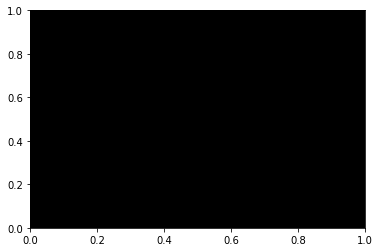

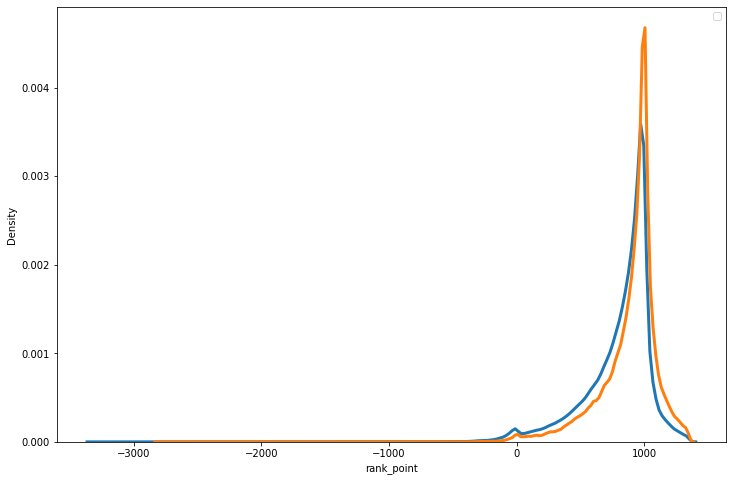

In [68]:
sample = df[df['rank_point'] <= 1347.5]

ax = plt.gca ()
plt.figure(figsize=(12,8))
ax.set_facecolor('black')
sns.distplot(sample.loc[sample['answerCode']==0, 'rank_point'],hist=False, kde_kws={'linewidth':3} ) #label='label=0'
sns.distplot(sample.loc[sample['answerCode']==1, 'rank_point'],hist=False, kde_kws={'linewidth':3} ) #label='label=1' 
plt.legend()
# plt.show()
plt.savefig('rankpoint.png', edgecolor='w', transparent =True, hist=False)

No handles with labels found to put in legend.


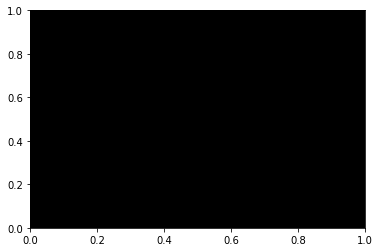

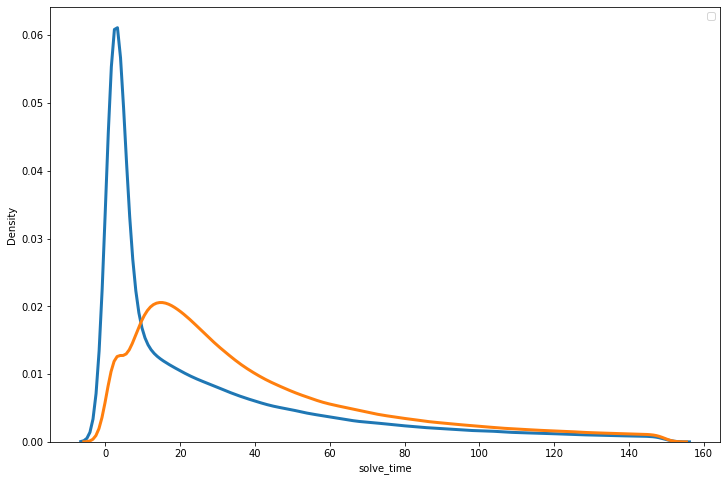

In [54]:
sample = df[df['solve_time'] <= 149.75]

ax = plt.gca ()
plt.figure(figsize=(12,8))
ax.set_facecolor('black')
sns.distplot(sample.loc[sample['answerCode']==0, 'solve_time'],hist=False, kde_kws={'linewidth':3} ) #label='label=0'
sns.distplot(sample.loc[sample['answerCode']==1, 'solve_time'],hist=False, kde_kws={'linewidth':3} ) #label='label=1' 
plt.legend()
# plt.show()
plt.savefig('solvetime.png', edgecolor='w', transparent =True, hist=False)

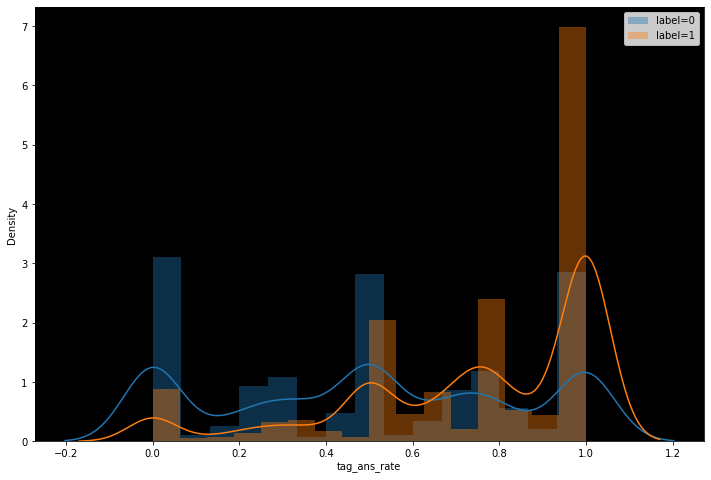

In [35]:
sample = df_last
plt.figure(figsize=(12,8))
ax = plt.gca() 
ax.set_facecolor('black')
sns.distplot(sample.loc[sample['answerCode']==0, 'tag_ans_rate'], label='label=0')
sns.distplot(sample.loc[sample['answerCode']==1, 'tag_ans_rate'], label='label=1')
# plt.distplot(sample.loc[sample['answerCode']==0, 'tag_ans_rate'], label='label=0')
# plt.distplot(sample.loc[sample['answerCode']==1, 'tag_ans_rate'], label='label=1')
plt.legend()
plt.show()

In [ ]:
'user_acc', 'u_test_cnt', 'test_ans_cnt',
       'test_ans_rate', 'u_tag_cnt', 'tag_ans_cnt', 'tag_ans_rate',
       'test_rate', 'grade', 'grade_test_level', 'que_rate', 'que_num',
       'que_num_rate', 'tag_rate', 'user_grade', 'sec_time', 'solve_time',
       'wrongP_time', 'correctP_time', 'test_mean', 'test_sum', 'ItemID_mean',
       'ItemID_sum', 'tag_mean', 'tag_sum', 'test_t_mean', 'test_t_std',
       'test_t_skew', 'assess_t_mean', 'assess_t_std', 'assess_t_skew',
       'tag_t_mean', 'tag_t_std', 'tag_t_skew', 'test_size', 'retest',
       'test_level', 'problem_number', 'test_tag_cumsum',
       'userID-solve_time-mean', 'userID-solve_time-std',
       'userID-solve_time-skew'

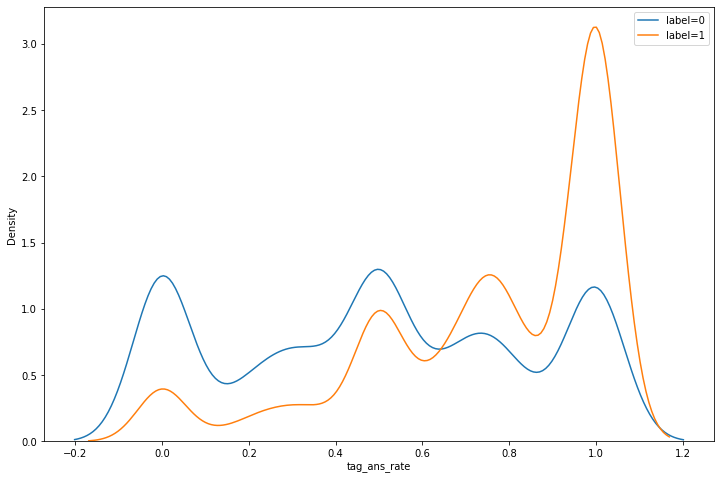

In [61]:
sample = df_last
plt.figure(figsize=(12,8))
ax.set_facecolor('black')
sns.distplot(sample.loc[sample['answerCode']==0, 'tag_ans_rate'], hist=False, label='label=0')
sns.distplot(sample.loc[sample['answerCode']==1, 'tag_ans_rate'], hist=False, label='label=1')

plt.legend()
# plt.show()
plt.savefig('ans_rate.png', edgecolor='w', transparent =True)